In [1]:
import warnings
warnings.filterwarnings('ignore')
from plotnine import *

from sklearn.decomposition import PCA
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, LogisticRegression
from sklearn.preprocessing import StandardScaler #Z-score variables
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split # simple TT split cv


import numpy as np

# 0. Together

Regularization is a way to adjust your *loss function* to reflect the belief that very small relationships between variables are *probably* due to weird quirks of our particular sample, and don't apply to the population as a whole. Forcing these small relationships to be smaller (Ridge) or zero (LASSO) can help our model perform better on *other* samples of data, therefore helping to combat overfitting.

LASSO specifically is used as a method of **variable selection**, because reducing a variables coefficient to zero is essentially the same thing as *removing* it from the model. While in ML we often don't care about or use p-values, the Statistician part of me needs to tell you this: *if you use LASSO to choose the variables in your model, the p-values and confidence intervals are NO LONGER VALID.* If you want to use p-values and CIs still, you need to correct for the fact that you "cherry-picked" the best variables from the model. See [this paper](https://www.pnas.org/content/112/25/7629) if you're ever going to do this. PLEASE.

## Ridge
Ridge Regression adds an extra penalty to the typical regression loss function: the L2 Norm. L2 refers to the fact that we take every coefficient, square it (i.e. take it to the 2nd power), add them together, and take the square root. You might notice that the L2 norm is also how we calculate distances, which is why the `np.linalg.norm()` function has been helpful to calculate distances!



## LASSO
LASSO adds a *different* extra penalty to the typical regression loss function: the L1 Norm. L1 refers to the fact that we take every coefficient, take the absolute value, and add them together. 





## Alternative Regularization Explanation

You can also think of Ridge and LASSO as having a "budget" for how big the sum of your (squared or absolute valued) coefficients can be.


This graph shows the concept of LASSO and RIDGE in a simple 2-parameter situation. The teal/blue circle (right) and square (left) represent the values for $\beta_1$ and $\beta_2$ that satisfy the "budget" for our coefficients. The dot in the middle of the red rings represents what the coefficients would be if we did not add a penalty at all. As you move from the inner to the outer red rings, the Residual Sums of Squares (RSS) goes up, meaning that our model is worse at accurately predicting data in our sample (remember that we're giving up accuracy in the *current* sample, to hopefully gain accuracy out-of-sample).

You can see that the coefficients chosen by LASSO/Ridge occur at the point of the teal/blue area that meets the red rings. This is because 1) when we penalize our model, it HAS to fit within the contraints we give it (the teal/blue area) but 2) we still want the RSS to be as small as possible (a model that's bad on ALL data sets isn't useful).

## How to choose between LASSO and Ridge?

In general: if you want to do variable selection (i.e. completely remove some variables), choose LASSO. But in the real world, people often use something called Elastic Net, which adds both LASSO (L1) *and* Ridge (L2) penalties to the loss function:



# 1. Comparing Coefficients of Regression, LASSO, and Ridge

The function `compare()` simulates a large dataset with 17 variables. 7 of those variables (the vowels, AEIOUYW) do have real relationships with the outcome, `X`. You can see the true coefficients in the part of the code that looks like this:

```
 # coefficients
    a = 8.23
    e = 3.48
    i = 2.97
    o = 5.12
    u = 7.83
    y = 12.34
    w = 1.38
    
```

10 of the variables (the consonants, BCDFGHJKLMN) do not have *any* relationship with `X` (i.e. their true coefficient is 0).


`compare()` then runs regular Regression (no penalty), Ridge Regression (L2 penalty) and LASSO (L1 penalty). 

In [2]:
n = 1000 #number of samples per model
nsims = 1000 # number of simulations
alpha = 0.1 # how harshly we penalize

In [3]:
def compare(n = 10000, alpha = 1):
    
    # Real Variables
    A = np.random.normal(0,1,n)
    E = np.random.normal(0,1,n)
    I = np.random.normal(0,1,n)
    O = np.random.normal(0,1,n)
    U = np.random.normal(0,1,n)
    Y = np.random.normal(0,1,n)
    W = np.random.normal(0,1,n)

    # Unrelated Variables
    B = np.random.normal(0,1,n)
    C = np.random.normal(0,1,n)
    D = np.random.normal(0,1,n)
    G = np.random.normal(0,1,n)
    H = np.random.normal(0,1,n)
    J = np.random.normal(0,1,n)
    K = np.random.normal(0,1,n)
    L = np.random.normal(0,1,n)
    M = np.random.normal(0,1,n)
    N = np.random.normal(0,1,n)
    
    
    # coefficients
    a = 8.23
    e = 3.48
    i = 2.97
    o = 5.12
    u = 7.83
    y = 12.34
    w = 1.38
    
    # Outcome
    X = 100 + A*a + E*e + I*i + O*o + U*u + Y*y + W*w + np.random.normal(0,15,n)
    
    
    X = (X - np.mean(X))/np.std(X) # z-score X
    # the other variables already have a mean of 0 and sd of 1
    

    # Data Frame
    df = pd.DataFrame({"A": A,"E": E, "I":I,"O":O,"U":U,
                       "B":B,"C":C,"D":D,"G":G,"H":H,"J":J,
                       "K":K,"L":L,"M":M,"N":N,"Y":Y,"W":W,
                       "X":X})

    feat = ["A","B","C","D","E","G","H","I","O", "U", "J","K","L","M","N", "Y","W"]

    #linear
    lr = LinearRegression()
    lr.fit(df[feat], df["X"])
    lr_co = lr.coef_

    #lasso
    lasso = Lasso(alpha = alpha,
                       fit_intercept = True, normalize = False,
                       tol=0.0000001, max_iter = 100000)
    lasso.fit(df[feat], df["X"])
    lasso_co = lasso.coef_

    #ridge
    ridge = Ridge(alpha = n*alpha, fit_intercept = True,
                       normalize = False, tol=0.0000001, max_iter = 100000)
    ridge.fit(df[feat], df["X"])
    ridge_co = ridge.coef_


    conames = feat*3
    coefs = np.concatenate([lr_co,lasso_co,ridge_co])

    model = np.repeat(np.array(["Linear", "LASSO", "Ridge"]), [17, 17, 17], axis=0)

    df = pd.DataFrame({"conames": conames,
                      "coefs": coefs,
                      "model": model})


    return(df)


This simulation below runs `compare()`, `nsims` times, and stores the results.

In [4]:
# running the simulation
sim = compare(n = n, alpha = alpha)

for i in range(1,nsims):
    sim = sim.append(compare(n = n, alpha = alpha), ignore_index = True)


## Plotting the Coefficients from the Simulation

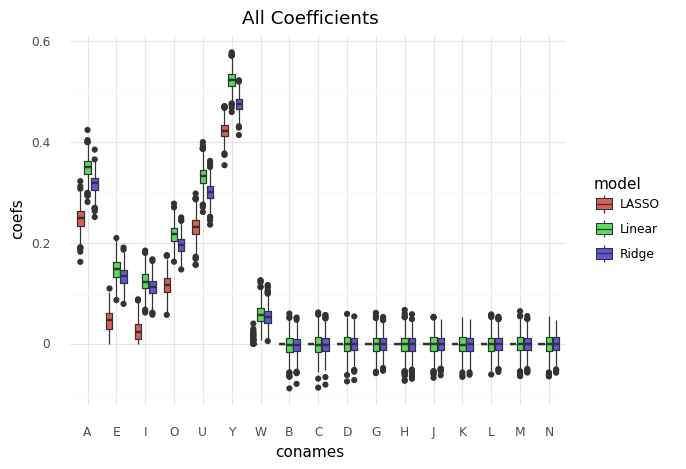

<ggplot: (8778750003158)>

In [5]:
#put the coefficents in order
sim["conames"] = pd.Categorical(sim["conames"], categories=["A", "E", "I", "O", "U", "Y", "W",
                                              "B","C","D","G","H","J","K","L", "M","N"])

    
# all coefficients
(ggplot(sim, aes(x = "conames",
                y = "coefs",
                fill = "model")) +
  geom_boxplot() + ggtitle("All Coefficients") + theme_minimal())



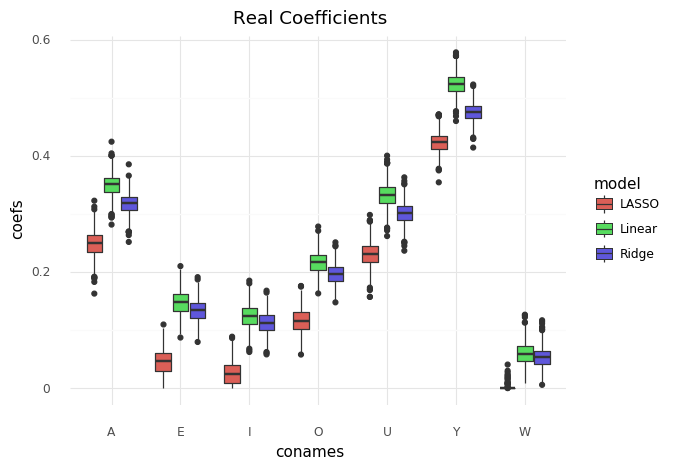

<ggplot: (8778749664874)>

In [6]:
#just vowels (these are the variables that DO have relationships with X)
(ggplot(sim.loc[sim['conames'].isin(["A", "E", "I", "O", "U", "Y", "W"]),]
, aes(x = "conames",
      y = "coefs",
      fill = "model")) +
  geom_boxplot() + ggtitle("Real Coefficients") + theme_minimal())
      

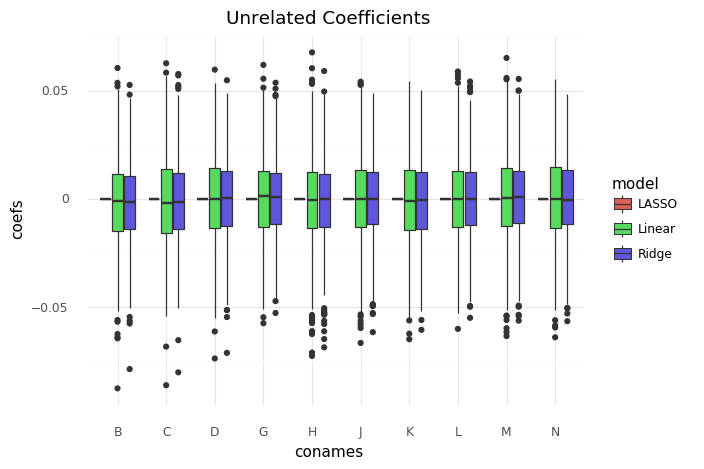

<ggplot: (8778750300663)>

In [7]:
#just consonants (these are the variables that DO NOT have relationships with X)

(ggplot(sim.loc[sim['conames'].isin(["B","C","D","G","H","J","K","L", "M","N"]),],
        aes(x = "conames",
        y = "coefs",
        fill = "model")) +
  geom_boxplot() + ggtitle("Unrelated Coefficients") + theme_minimal())

### *Question*

Compare the ranges (using the boxplots generated above) of coefficients when using Linear Regression (unpenalized), LASSO (L1 penalty), and Ridge (L2 penalty). What patterns do you see in the coefficients that *do* have relationships with X (vowels)? What patterns do you see in the coefficients that *do not* have relationships with X (consonants)?

<img src="https://drive.google.com/uc?export=view&id=1ghyQPx1N8dmU3MV4TrANvqNhGwnLni72" width = 200px />


### Answer

DO have relationships: When the variables have strong relationships with the outcome, the Ridge and LASSO coefficients are *close* to what they would be without any regularization, though both do drag them down a *little* on average. This is probably because these variables improve the fit of the model so much (the first part of the loss function) that they "make up for" their larger coefs. Interestingly, `W`, which has a SMALL relationship with the outcome is actually dragged to 0 by LASSO...a risk you take when using LASSO: if the effect--though real--isn't strong, LASSO may get rid of it.

DO NOT have relationships:LASSO just absolutely flattens all of these to EXACTLY 0, which is what it is designed to do. Ridge draws these values closer to 0 compared to Linear Regression, but still allows them to be non-zero.

### *Question*

What do you think will happen if you increase `alpha`, which controls how much we penalize large coefficients? Try it out below:

<img src="https://drive.google.com/uc?export=view&id=1ghyQPx1N8dmU3MV4TrANvqNhGwnLni72" width = 200px />

### Answer

The higher the "harshness" of the penalty the more effects LASSO will draw to 0 and the smaller Ridge will make coefficients since the penalty part of the loss function becomes a "bigger deal" compared to the fit part.

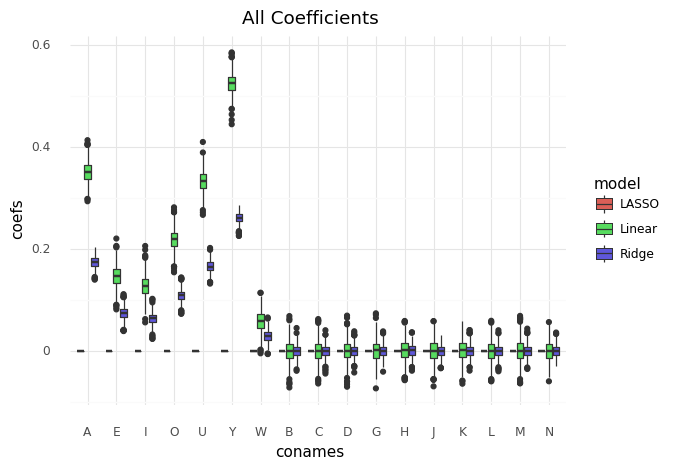

<ggplot: (8778750723335)>

In [8]:
n = 1000 #number of samples per model
nsims = 1000 # number of simulations
alpha = 1 # how harshly we penalize


# running the simulation
sim = compare(n = n, alpha = alpha)

for i in range(1,nsims):
    sim = sim.append(compare(n = n, alpha = alpha), ignore_index = True)

    
    
#put the coefficents in order
sim["conames"] = pd.Categorical(sim["conames"], categories=["A", "E", "I", "O", "U", "Y", "W",
                                              "B","C","D","G","H","J","K","L", "M","N"])

    
# all coefficients
(ggplot(sim, aes(x = "conames",
                y = "coefs",
                fill = "model")) +
  geom_boxplot() + ggtitle("All Coefficients") + theme_minimal())



### *Question*

What do you think will happen if you decrease `alpha`, which controls how much we penalize large coefficients? Try it out below (you can set `alpha` to be very small, but for computational reasons, don't set it to be exactly zero):

<img src="https://drive.google.com/uc?export=view&id=1ghyQPx1N8dmU3MV4TrANvqNhGwnLni72" width = 200px />


### Answer

After a while, if the penalty is so small, LASSO and ridge will basically look like linear regression since the penalty is almost 0.

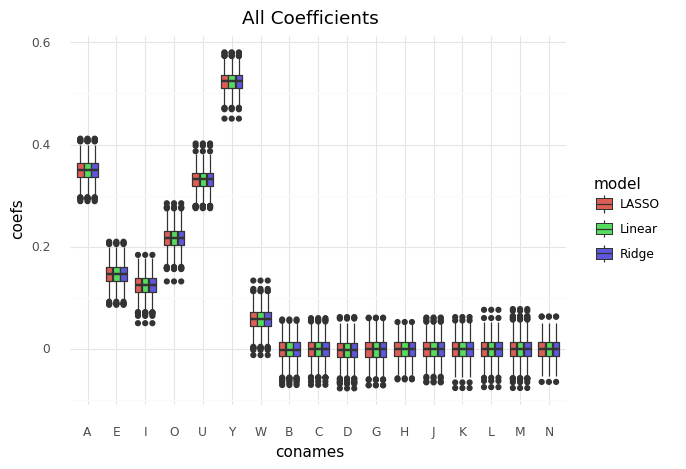

<ggplot: (8778749971237)>

In [9]:
n = 1000 #number of samples per model
nsims = 1000 # number of simulations
alpha =  0.000001# how harshly we penalize


# running the simulation
sim = compare(n = n, alpha = alpha)

for i in range(1,nsims):
    sim = sim.append(compare(n = n, alpha = alpha), ignore_index = True)

    
    
#put the coefficents in order
sim["conames"] = pd.Categorical(sim["conames"], categories=["A", "E", "I", "O", "U", "Y", "W",
                                              "B","C","D","G","H","J","K","L", "M","N"])

    
# all coefficients
(ggplot(sim, aes(x = "conames",
                y = "coefs",
                fill = "model")) +
  geom_boxplot() + ggtitle("All Coefficients") + theme_minimal())



# 2. Building your own Regularized Models

Back when we learned Logistic Regression, I briefly mentioned that in sklearn, `LogisticRegression()` does regularization by default. Now you know what that really means!

Using the Beyonce data below, use dancebility, energy, speechiness, acousticness, instrumentalness, duration_ms, and liveness to predict mode. 

Build one model with NO penalty, and one with a LASSO (L1) penalty. See [documentaion](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) if you need a refresher on how to change the `penalty` argument.


How do the coefficients compare between the two models?

<img src="https://drive.google.com/uc?export=view&id=1ghyQPx1N8dmU3MV4TrANvqNhGwnLni72" width = 200px />

### Answer

The coefs are largely smaller (though not a TON, meaning that the variables do improve the fit of the model enough to not be dragged to 0, at least with the harshness that LogisticRegression() chose).

In [10]:
bey = pd.read_csv("https://raw.githubusercontent.com/cmparlettpelleriti/CPSC392ParlettPelleriti/master/Data/Beyonce_data.csv")

X = bey[["danceability", "energy", "speechiness", "acousticness", "instrumentalness", "duration_ms", "liveness"]]
y = bey["mode"]

z = StandardScaler()
X = z.fit_transform(X)
logReg = LogisticRegression(penalty = "none")
logLasso = LogisticRegression(penalty = "l1", solver = "liblinear")

logReg.fit(X,y)
logLasso.fit(X,y)

print(logReg.coef_[0])
print(logLasso.coef_[0])


[-0.82616188 -0.42438465 -0.27849143 -0.77117023 -0.51271372  0.05595349
 -0.11623507]
[-0.77042563 -0.38376514 -0.26387855 -0.70558953 -0.48130529  0.04287913
 -0.10036107]


# 3. Taking a Look at Regularization and Overfitting

In lecture (and hopefully in class), we've talked about the fact that regularization helps prevent overfitting. The datasets X1, X2, X3, and X4 are all (fake; **already z-scored**) samples from the **same** population. Fit a regular linear regression model on dataset X1, and then see how well it performs (in terms of MSE) on X2, X3, and X4. Essentiall, you're treating X1 as the train set, and X2, X3, and X4 as the test set.

Then fit a Ridge model on X1, and then see how well it performs (in terms of MSE) on X2, X3, and X4. Make sure you're aware of when the numbers are in scientific notation. 


Which (Linear or Ridge) is higher on X1? What about on X2, X3, and X4? 

<img src="https://drive.google.com/uc?export=view&id=1ghyQPx1N8dmU3MV4TrANvqNhGwnLni72" width = 200px />

### Answer

At least for the "harshness" of penalty that Ridge automatically calculated (we can manually set it to be higher or lower), Ridge has MUCH less overfitting. We can see this through the difference between the train (data set 1) and test (the other data sets) MSEs. We could maybe even make it higher. 

In [8]:
X1 = pd.read_csv("https://raw.githubusercontent.com/cmparlettpelleriti/CPSC392ParlettPelleriti/master/Data/regX1.csv")
X2 = pd.read_csv("https://raw.githubusercontent.com/cmparlettpelleriti/CPSC392ParlettPelleriti/master/Data/regX2.csv")
X3 = pd.read_csv("https://raw.githubusercontent.com/cmparlettpelleriti/CPSC392ParlettPelleriti/master/Data/regX3.csv")
X4 = pd.read_csv("https://raw.githubusercontent.com/cmparlettpelleriti/CPSC392ParlettPelleriti/master/Data/regX4.csv")


predictors = ["X" + str(i) for i in range(1,100)]

X1.shape



(120, 101)

In [9]:
l1 = LinearRegression()
r1 = Ridge(alpha = 750)

l1.fit(X1[predictors], X1["outcome"])
r1.fit(X1[predictors], X1["outcome"])

Ridge(alpha=750, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

linear mse is :  4.4965768979761954e-05
ridge mse is  :  0.6473660639917623
linear mse is :  0.5507501302303798
ridge mse is  :  0.8402680127606477
linear mse is :  0.6180686980168175
ridge mse is  :  0.8400538155578179
linear mse is :  0.47521080499265367
ridge mse is  :  0.8090060524772797


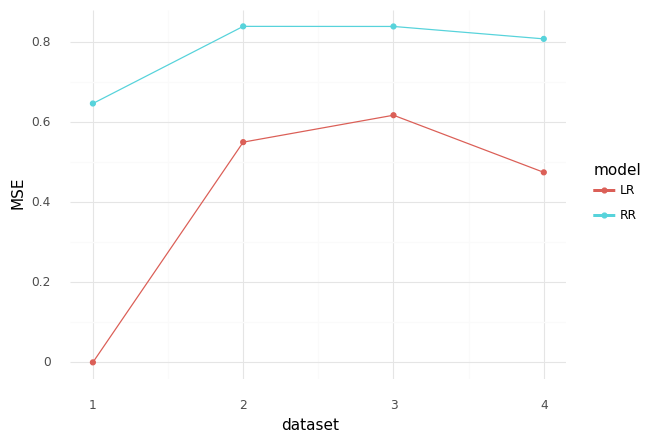

<ggplot: (8776503028752)>

In [10]:
# CALCULATE ALL THE MSE's below:

### YOUR CODE HERE ###

# MSEs for X1
lin1 = mean_squared_error(l1.predict(X1[predictors]), X1["outcome"]) # linear regression
rid1 = mean_squared_error(r1.predict(X1[predictors]), X1["outcome"])# ridge regression

print("linear mse is : ", lin1)
print("ridge mse is  : ", rid1)

# MSEs for X2
lin2 = mean_squared_error(l1.predict(X2[predictors]), X2["outcome"]) # linear regression
rid2 = mean_squared_error(r1.predict(X2[predictors]), X2["outcome"])# ridge regression

print("linear mse is : ", lin2)
print("ridge mse is  : ", rid2)

# MSEs for X3
lin3 = mean_squared_error(l1.predict(X3[predictors]), X3["outcome"]) # linear regression
rid3 = mean_squared_error(r1.predict(X3[predictors]), X3["outcome"])# ridge regression

print("linear mse is : ", lin3)
print("ridge mse is  : ", rid3)

# MSEs for X4
lin4 = mean_squared_error(l1.predict(X4[predictors]), X4["outcome"]) # linear regression
rid4 = mean_squared_error(r1.predict(X4[predictors]), X4["outcome"])# ridge regression

print("linear mse is : ", lin4)
print("ridge mse is  : ", rid4)

plotdf = pd.DataFrame({"MSE": [lin1, lin2, lin3, lin4, rid1, rid2, rid3, rid4],
                     "dataset": [1,2,3,4,1,2,3,4],
                     "model": ["LR", "LR", "LR", "LR", "RR", "RR","RR", "RR"]})

ggplot(plotdf, aes(x = "dataset", y = "MSE", color = "model")) + geom_line() + geom_point() + theme_minimal()